In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## artist_id 别名规范化字典
alias_map 别名 -> 实名 

In [2]:
alias_map = np.load("obj/alias_map.npy",allow_pickle=True).item()

# 1. 从文件中构造原始矩阵

In [3]:
"""
记录id到矩阵索引的映射
"""
user_id_index = {}
user_cnt = 0 # index 计数
artist_id_index = {}
artist_cnt = 0 # index 计数


# 测试集保留
test = {}  #（ (user,artist) : score )
# 训练集记录
train_map = {}  # ((user_index,artist_index) : score)

# 构造训练集和测试集
import random
def add_item(user, artist, score):
    """
    需要 alias_map
    20%几率将数据置0，作为测试集
    """
    # artist 别名规范化
    artist = alias_map.get(artist,artist)
    
    # 测试集：从训练集中随机抽取20%记录score作为测试，并置score=0写入训练集
    import random
    if random.random() < 0.2:
        test[(user,artist)] = score
        score = 0
        
    # 训练集
    '''
    user in index ? index : new index, new row
    artist in index ? index : new index, new col
    '''
    global user_cnt
    user_index=user_cnt
    if user in user_id_index:
        user_index = user_id_index[user]
    else:
        user_id_index[user] = user_index
        user_cnt +=1
        
    global artist_cnt
    artist_index=artist_cnt
    if artist in artist_id_index:
        artist_index = artist_id_index[artist]
    else:
        artist_id_index[artist] = artist_index
        artist_cnt +=1
    
    return (user_index,artist_index),score


# 读取文件
n=0
eno =0

import random

with open("user_artist_data.txt",encoding="utf8") as f:
    # 文件总计2400+w行
    for l in f:
#         if random.random() < 0.1:
            n=n+1
            m = re.match(r"(\d+) (\d+) (\d+)",l)
            eles = m.groups() if m is not None else () 
            if len(eles) is 3:
                key,value = add_item(eles[0], eles[1], int(eles[2]))
                train_map[key] = value
            else:
                eno+=1
    #             print(str(n)+" - error: "+l)
            if n%100000 is 0:
                print(f"compete {n}", end="\r")

print("error count : "+str(eno))
print("lines count : "+str(n))

error count : 00
lines count : 24296858


# 2. 矩阵分解（梯度下降法）

train_map 为原始矩阵 $M$

分解即  $R \approx PQ = \hat{R} $

初始化 $P Q$ 矩阵 分别为 $m*k, k*n$

In [ ]:
# 定义隐含主题个数
K = 5 
# 初始化矩阵

m,n = user_cnt, artist_cnt
p = np.random.rand(m,K)
q = np.random.rand(K,n)

In [29]:
# 读取缓存矩阵，用于继续训练
p = np.load("obj/p_gd.npy",allow_pickle=True)
q = np.load("obj/q_gd.npy",allow_pickle=True)

In [33]:
# 缓存矩阵，手动checkpoint
np.save("obj/p_gd.npy",p)
np.save("obj/q_gd.npy",q)

In [18]:
import math
def loger(x):
    if x<=2:
        return 1
    else:
        return np.log2(x)

def astep(a=0.00001,b=0.001):
    n = 0
    loss = 0 # 初始化损失项
    reg = 0 # 初始化正则项
    for i,j in list( train_map.keys()):
        if n%200000 == 0 :
            print(f"processing  {n/241333:.2f}%  loss = {loss + (b/2)*reg:.2f}", end="\r")
        n+=1
        value = loger( train_map.get((i,j)) )
        eij = value - np.dot(p[i,:],q[:,j])
        if math.isinf(eij):
            print(i,j,eij,reg,loss,n,p[i,:])
            return loss
        p[i,:] = p[i,:] + a*(eij*q[:,j] - b*p[i,:])
        q[:,j] = q[:,j] + a*(eij*p[i,:] - b*q[:,j])
        reg += np.sum( p[i,:]**2 + q[:,j]**2 )
        loss += ( value - np.dot(p[i,:],q[:,j]) )**2
    print(f"processing  100%  loss = {loss + (b/2)*reg:.2f}")
    return loss + (b/2)*reg

In [49]:
for i in range(5):
    print("\n",astep())

processing  100%  loss = 81930759.5272
 81934868.13228196
processing  100%  loss = 78657425.5286
 78661695.23638596
processing  100%  loss = 76476311.0975
 76480723.72115158
processing  100%  loss = 74898442.5039
 74902977.65066959
processing  100%  loss = 73681153.1544
 73685792.50292715


In [13]:
astep(a=0.001,b=0.001)

60460950.40692349

In [15]:
%%time
astep(a=0.005,b=0.001)

CPU times: user 10min 44s, sys: 9.17 s, total: 10min 53s
Wall time: 10min 51s


50056531.234473065

In [31]:
%%time
astep(a=0.002,b=0.001)

processing  100%  loss = 50027085.5968
CPU times: user 10min 33s, sys: 11.4 s, total: 10min 45s
Wall time: 10min 39s


50027085.59433063

In [32]:
%%time
astep(a=0.002,b=0.001)

processing  100%  loss = 49627886.3693
CPU times: user 10min 27s, sys: 17.8 s, total: 10min 45s
Wall time: 10min 30s


49627886.36159738

In [50]:
loss_y = [81930759.5272,78657425.5286,76476311.0975,74898442.5039,73681153.1544,60460950.4158,50056531.234473065,50027085.5968,49627886.3693]
alpha_x = np.cumsum([0.00001,0.00001,0.00001,0.00001,0.00001,0.001,0.005,0.002,0.002]) 

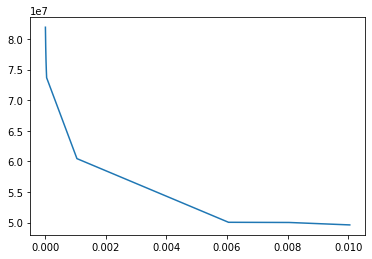

In [51]:
# 绘制 loos- cum_alpha （代价-累计学习率）曲线
plt.plot(alpha_x,loss_y)

# 3. 测试与评价